In [1581]:
import numpy as np
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\Blair Lin\quantTrade_2025\optionDailyMtM\data_測試")
# Standard normal PDF and CDF
N_pdf = stats.norm.pdf
N = stats.norm.cdf


def BS_Price(S, K, T, rd, rf, sigma, CP):
    """
    Black (forward) option price. CP = "C" for call, "P" for put.
    S: spot
    K: strike
    T: time to expiry (in years)
    rd: domestic rate (discount)
    rf: foreign rate (or dividend yield)
    sigma: vol (annualized)
    """
    if sigma <= 0 or T <= 0:
        # fallback to intrinsic (discounted)
        if CP == "C":
            return max(0.0, S * np.exp(-rf * T) - K * np.exp(-rd * T))
        else:
            return max(0.0, K * np.exp(-rd * T) - S * np.exp(-rf * T))

    F = S * np.exp((rd - rf) * T)
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if CP == "C":
        I = 1.0
    elif CP == "P":
        I = -1.0
    else:
        raise ValueError("CP must be 'C' or 'P'")

    # Black's formula (discounted)
    price = I * np.exp(-rd * T) * (F * N(I * d1) - K * N(I * d2))
    return price

def BS_Delta(S, K, T, rd, rf, sigma, CP):
    """
    Delta w.r.t. spot S for Black model.
    """
    if sigma <= 0 or T <= 0:
        if CP == "C":
            return 1.0 if S * np.exp(-rf * T) > K * np.exp(-rd * T) else 0.0
        else:
            return -1.0 if S * np.exp(-rf * T) < K * np.exp(-rd * T) else 0.0

    F = S * np.exp((rd - rf) * T)
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))

    if CP == "C":
        I = 1.0
    else:
        I = -1.0

    # Delta w.r.t spot (Black): exp(-rf*T) * N(I*d1) * I
    delta = I * np.exp(-rf * T) * N(I * d1)
    return delta

def BS_Gamma(S, K, T, rd, rf, sigma, CP=None):
    """
    Gamma w.r.t spot (same for calls and puts).
    """
    if sigma <= 0 or T <= 0:
        return 0.0

    F = S * np.exp((rd - rf) * T)
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))

    # Black gamma: N_pdf(d1) / (S * sigma * sqrt(T)) * exp(-rf*T)
    gamma = N_pdf(d1) * np.exp(-rf * T) / (S * sigma * np.sqrt(T))
    return gamma

def BS_Vega(S, K, T, rd, rf, sigma, CP=None):
    """
    Vega: sensitivity to vol (per 1 vol point, i.e. if sigma in decimal,
    vega gives change in price per 1 sigma unit). Original code divided by 100;
    keep that if you want vega per 1% vol: return vega/100.
    """
    if sigma <= 0 or T <= 0:
        return 0.0

    F = S * np.exp((rd - rf) * T)
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))

    # Black vega: S * exp(-rf*T) * sqrt(T) * N_pdf(d1)
    vega = S * np.exp(-rf * T) * np.sqrt(T) * N_pdf(d1)
    return vega  # divide by 100 if you want per-1%-point

def BS_Theta(S, K, T, rd, rf, sigma, CP):
    """
    Theta per year (returning annualized theta). If you want per-day, divide by 365.
    """
    if sigma <= 0 or T <= 0:
        return 0.0

    F = S * np.exp((rd - rf) * T)
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if CP == "C":
        I = 1.0
    elif CP == "P":
        I = -1.0
    else:
        raise ValueError("CP must be 'C' or 'P'")

    term1 = -S * N_pdf(d1) * sigma * np.exp(-rf * T) / (2.0 * np.sqrt(T))
    term2 = I * rf * S * N(I * d1) * np.exp(-rf * T)
    term3 = -I * rd * K * np.exp(-rd * T) * N(I * d2)
    theta = term1 + term2 + term3
    return theta  # divide by 365 for per-day theta

def BS_Rd(S, K, T, rd, rf, sigma, CP):
    """
    Rho w.r.t domestic rate rd (sensitivity of price to rd).
    """
    if sigma <= 0 or T <= 0:
        return 0.0

    F = S * np.exp((rd - rf) * T)
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if CP == "C":
        I = 1.0
    elif CP == "P":
        I = -1.0
    else:
        raise ValueError("CP must be 'C' or 'P'")

    rho = I * K * T * np.exp(-rd * T) * N(I * d2)
    return rho

def BS_Rf(S, K, T, rd, rf, sigma, CP):
    """
    Sensitivity to foreign rate (or dividend yield) rf.
    """
    if sigma <= 0 or T <= 0:
        return 0.0

    F = S * np.exp((rd - rf) * T)
    d1 = (np.log(F / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))

    if CP == "C":
        I = 1.0
    elif CP == "P":
        I = -1.0
    else:
        raise ValueError("CP must be 'C' or 'P'")

    rf_sens = -I * S * T * np.exp(-rf * T) * N(I * d1)
    return rf_sens

In [1582]:
from datetime import datetime
CCY_LIST = ['USDJPY']
TODAY = datetime.now().strftime("%Y-%m-%d")

# VOL及VOL EXERCISE DAY

In [1583]:
import numpy as np
import pandas as pd
from datetime import datetime
from xbbg import blp

# Ensure CCY_LIST is defined somewhere in your environment, e.g.
# CCY_LIST = ["EURUSD", "USDJPY", "AUDUSD"]
# If not, define it here for testing:
# CCY_LIST = ["EURUSD"]

tenor = ["ON", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "6M", "9M", "1Y"]

def vol_download(currency: str) -> pd.DataFrame:
    option_type = ["V", "25R", "25B", "10R", "10B"]

    # build tickers in the same order as the original code (option_type outer, tenor inner)
    vol_ticker = [currency + j + i + " BGN Curncy" for j in option_type for i in tenor]
    # arrays describing the MultiIndex for columns (must match vol_ticker order)
    vol_column_tenor = [i for j in option_type for i in tenor]
    vol_column_type = [j for j in option_type for i in tenor]

    # today (end date)
    today = datetime.now().strftime("%Y-%m-%d")

    # fetch time series: one field -> DataFrame with columns == tickers
    vol = blp.bdh(tickers=vol_ticker, flds=['PX_LAST'], start_date='2000-01-01', end_date=today, Per='D', Calendar='5D')
    vol.index = pd.DatetimeIndex(vol.index)

    # forward-fill missing values
    vol.fillna(method='ffill', inplace=True)

    # convert columns to a MultiIndex (tenor, option_type)
    vol.columns = pd.MultiIndex.from_arrays([vol_column_tenor, vol_column_type], names=["tenor", "type"])

    # add currency as first level of the index (so concatenation across currencies is straightforward)
    vol_index_currency = [currency] * len(vol)
    vol.index = pd.MultiIndex.from_arrays([vol_index_currency, vol.index], names=["currency", "date"])

    return vol


# Build the combined VOL dataframe for all currencies in CCY_LIST
VOL = pd.DataFrame()

# Ensure CCY_LIST is defined externally; error if not.
try:
    CCY_LIST
except NameError:
    raise NameError("CCY_LIST is not defined. Define CCY_LIST = ['EURUSD', ...] before running this script.")

for currency in CCY_LIST:
    vol = vol_download(currency)
    VOL = pd.concat([VOL, vol], axis=0)

# VOL has columns MultiIndex (tenor, type). Stack the tenor level so index becomes (currency, date, tenor)
VOL = VOL.stack(level=0)  # now index = (currency, date, tenor) and columns = option types like 'V','25R',...

# Ensure column names we expect exist; if not, they'll be treated as NaN
# Compute standard interpolated option columns (25C, 25P, 10C, 10P)
# Use .astype(float) to ensure numeric operations
for col in ["V", "25R", "25B", "10R", "10B"]:
    if col not in VOL.columns:
        VOL[col] = np.nan
VOL = VOL.astype(float)

VOL["25C"] = (VOL["25B"] + VOL["V"]) + (VOL["25R"] / 2)
VOL["25P"] = (VOL["25B"] + VOL["V"]) - (VOL["25R"] / 2)
VOL["10C"] = (VOL["10B"] + VOL["V"]) + (VOL["10R"] / 2)
VOL["10P"] = (VOL["10B"] + VOL["V"]) - (VOL["10R"] / 2)

# Drop the raw inputs we no longer need
VOL = VOL.drop(["10B", "10R", "25B", "25R"], axis=1, errors='ignore')

# Reorder columns to the desired structure: 10C,25C,V,25P,10P
desired_cols = ["10C", "25C", "V", "25P", "10P"]
# keep only existing desired columns in that order
# cols_to_keep = [c for c in desired_cols if c in VOL.columns]
cols_to_keep = desired_cols
VOL = VOL.reindex(columns=cols_to_keep)

# Rename columns to percentiles as in original code
VOL.columns = [0.1, 0.25, 0.5, 0.75, 0.9][: len(VOL.columns)]

# Reset index into columns (optional) and set index names as requested
VOL = VOL.reset_index()
VOL["tenor"] = pd.Categorical(VOL["tenor"], categories=tenor, ordered=True)
VOL = VOL.sort_values(["currency", "date", "tenor"])
VOL = VOL.set_index(["currency", "date", "tenor"])
VOL.index.names = ["currency", "date", "tenor"]

# VOL is ready
# Example: show head
# print(VOL.head())

In [1584]:
import pandas as pd
from datetime import datetime
import os

# Ensure tenor and CCY_LIST are defined in your environment, or define them here:
tenor = ["ON", "1W", "2W", "3W", "1M", "2M", "3M", "4M", "6M", "9M", "1Y"]
# Example: CCY_LIST = ["EURUSD", "USDJPY"]
# CCY_LIST must be defined before running this script.
try:
    CCY_LIST
except NameError:
    raise NameError("CCY_LIST is not defined. Define CCY_LIST = ['EURUSD', ...] before running this script.")

# Path to the Excel file - adjust as needed
input_path = r"C:\Users\Blair Lin\quantTrade_2025\optionDailyMtM\data_更新版\volExpDate.xlsx"
if not os.path.exists(input_path):
    raise FileNotFoundError(f"{input_path} not found")

# Result DataFrame: columns = tenor, index will be a MultiIndex (currency, date)
VOL_exercise_date = pd.DataFrame(columns=tenor)

for currency in CCY_LIST:
    # read sheet into DataFrame
    vol_exercise_date = pd.read_excel(input_path, sheet_name=currency)

    # Ensure there is a 'Date' column
    if "Date" not in vol_exercise_date.columns:
        raise KeyError(f"'Date' column not found in sheet '{currency}'")

    # set index from Date column (parse dates robustly)
    # Some Date cells may already be datetimes, others strings 'YYYY/MM/DD'
    vol_exercise_date["Date_parsed"] = pd.to_datetime(vol_exercise_date["Date"], format="%Y/%m/%d", errors="coerce")
    # If parsing with format failed, try generic parse
    mask_na = vol_exercise_date["Date_parsed"].isna()
    if mask_na.any():
        vol_exercise_date.loc[mask_na, "Date_parsed"] = pd.to_datetime(vol_exercise_date.loc[mask_na, "Date"], errors="coerce")

    # drop rows where Date couldn't be parsed
    vol_exercise_date = vol_exercise_date.dropna(subset=["Date_parsed"])

    # keep only tenor columns that exist in the sheet (avoid KeyError)
    present_tenors = [t for t in tenor if t in vol_exercise_date.columns]
    if not present_tenors:
        # nothing to append for this sheet
        continue

    vol_exercise_date = vol_exercise_date.set_index("Date_parsed")[present_tenors]
    # convert index to plain python date objects (if you prefer)
    vol_exercise_date.index = vol_exercise_date.index.date
    vol_exercise_date.index = pd.DatetimeIndex(vol_exercise_date.index)

    # create a MultiIndex with currency as first level and date as second
    multi_index = pd.MultiIndex.from_arrays(
        [[currency] * len(vol_exercise_date), list(vol_exercise_date.index)],
        names=["currency", "date"],
    )
    vol_exercise_date.index = multi_index

    # concat to the master DataFrame
    VOL_exercise_date = pd.concat([VOL_exercise_date, vol_exercise_date], axis=0, sort=False)

# Optional: ensure final index is a MultiIndex with the expected names
if not isinstance(VOL_exercise_date.index, pd.MultiIndex):
    # try to interpret existing index as tuples
    try:
        idx0 = [i[0] for i in VOL_exercise_date.index]
        idx1 = [i[1] for i in VOL_exercise_date.index]
        VOL_exercise_date.index = pd.MultiIndex.from_arrays([idx0, idx1], names=["currency", "date"])
    except Exception:
        pass

VOL_exercise_date.index.names = ["currency", "date"]
# show result
# print(VOL_exercise_date.head())

# SPOT及SWAP

In [1585]:
spot = pd.DataFrame(columns = CCY_LIST)
spot_ticker = [i+ " CMTK Curncy" for i in CCY_LIST]
spot = blp.bdh(tickers=spot_ticker , flds=['PX_LAST'] , start_date='2000-01-01', end_date=TODAY,Per = 'D',Calendar='5D')
spot.columns = CCY_LIST
spot_diff = spot.diff()
spot_chg = spot.diff()/spot

In [1586]:
tenor2 = ["ON","1W","2W","3W","1M","2M","3M","4M","6M","9M","12M"]
def forward_download(currency):
    swap_ticker=[]
    swap_column_1=[]
    swap_column_2=[]
 
    for i in tenor2:
        swap_ticker.append(currency+i+" CMTK Curncy")

    today = datetime.now().strftime("%Y-%m-%d")
    swap = blp.bdh(tickers=swap_ticker , flds=['PX_LAST'] , start_date='2000-01-01', end_date=today,Per = 'D',Calendar='5D')
    swap.fillna(method='ffill',inplace=True)
    swap.columns = tenor2
 
    scale = blp.bdp(currency +" CURNCY","FWD_SCALE")
    swap = swap / (10**scale.iloc[0,0])
 
    spot_ticker = currency + " CMTK Curncy"
    spot = blp.bdh(tickers=spot_ticker , flds=['PX_LAST'] , start_date='2000-01-01', end_date=today,Per = 'D',Calendar='5D')
    spot.columns = [currency]
 
    forward = pd.DataFrame()
    for i in swap.columns:
        forward[i] = swap[i] + spot[currency]
    forward.index = pd.DatetimeIndex(forward.index)
    
    forward_index1 = np.array([currency]*len(forward))
    forward_index2 = forward.index
    forward = forward.set_index([forward_index1,forward_index2])
    return forward

In [1587]:
FORWARD = pd.DataFrame(columns = tenor2)
 
for currency in CCY_LIST:
	forward = forward_download(currency)
	FORWARD = pd.concat([FORWARD,forward],axis=0)
 
   
FORWARD_index1 = [i[0] for i in FORWARD.index]
FORWARD_index2 = [i[1] for i in FORWARD.index]
FORWARD= FORWARD.set_index([FORWARD_index1,FORWARD_index2])   
 
print(FORWARD)

                          ON        1W        2W        3W        1M  \
USDJPY 2000-01-03  101.43525  101.3425  101.2325  101.1230  100.9360   
       2000-01-04  103.20405  103.1105  102.9970  102.8827  102.7190   
       2000-01-05  104.12395  104.0295  103.9175  103.8045  103.5855   
       2000-01-06  105.21328  105.1180  105.0035  104.8910  104.6801   
       2000-01-07  105.32328  105.2265  105.1120  104.9945  104.7965   
...                      ...       ...       ...       ...       ...   
       2025-11-12  154.60465  154.5117  154.4036  154.2923  154.1405   
       2025-11-13  154.70348  154.5943  154.4975  154.3886  154.2522   
       2025-11-14  154.63495  154.5707  154.4582  154.3494  154.2134   
       2025-11-17  154.67448  154.5814  154.4691  154.3604  154.2243   
       2025-11-18  155.17480  155.0664  154.9701  154.8613  154.6952   

                         2M        3M        4M        6M        9M       12M  
USDJPY 2000-01-03  100.4775   99.9750   99.4450   98.49

# Forward date

In [1588]:
Fwd_date = pd.DataFrame()
fwdTenor = tenor2

for currency in CCY_LIST:  
    fwd_date = pd.read_excel(r"C:\Users\Blair Lin\quantTrade_2025\optionDailyMtM\data_更新版\fwdValDate.xlsx",sheet_name=currency)
    fwd_date.index = fwd_date["Date"]
    fwd_date.index = pd.DatetimeIndex(fwd_date.index)
 
    # rate_date = rate_date[tenor]
    fwd_date = fwd_date.iloc[1:]
	#rate_date = rate_date.applymap(lambda x : datetime.strptime(x, '%Y/%m/%d'))
    fwd_date_index1 = [currency] * len(fwd_date)
    # rate_date_index2 = [i.date() for i in rate_date.index]
    fwd_date_index2 = fwd_date.index
    fwd_date = fwd_date.set_index([fwd_date_index1,fwd_date_index2])
   
    Fwd_date = pd.concat([Fwd_date,fwd_date],axis=0)
   
Fwd_date



Date  Unnamed: 1                   ON  \
       Date                                                     
USDJPY 2000-01-01 2000-01-01         NaN  2000-01-04 00:00:00   
       2000-01-03 2000-01-03         NaN  2000-01-04 00:00:00   
       2000-01-04 2000-01-04         NaN  2000-01-05 00:00:00   
       2000-01-05 2000-01-05         NaN  2000-01-06 00:00:00   
       2000-01-06 2000-01-06         NaN  2000-01-07 00:00:00   
...                      ...         ...                  ...   
       2025-11-12 2025-11-12         NaN  2025-11-13 00:00:00   
       2025-11-13 2025-11-13         NaN  2025-11-14 00:00:00   
       2025-11-14 2025-11-14         NaN  2025-11-17 00:00:00   
       2025-11-17 2025-11-17         NaN  2025-11-18 00:00:00   
       2025-11-18 2025-11-18         NaN           2025-11-19   

                                    1W                   2W  \
       Date                                                   
USDJPY 2000-01-01  2000-01-12 00:00:00  2000-01-19 00:00:00   
       2000-01-03  2000-01-12 00:00:00  2000-01-19 00:00:00   
       2000-01-04  2000-01-13 00:00:00  2000-01-20 00:00:00   
       2000-01-05  2000-01-14 00:00:00  2000-01-21 00:00:00   
       2000-01-06  2000-01-18 00:00:00  2000-01-25 00:00:00   
...                                ...                  ...   
       2025-11-12  2025-11-21 00:00:00  2025-11-28 00:00:00   
       2025-11-13  2025-11-25 00:00:00  2025-12-01 00:00:00   
       2025-11-14  2025-11-25 00:00:00  2025-12-02 00:00:00   
       2025-11-17  2025-11-26 00:00:00  2025-12-03 00:00:00   
       2025-11-18           2025-11-28           2025-12-04   

                                    3W                   1M  \
       Date                                                   
USDJPY 2000-01-01  2000-01-26 00:00:00  2000-02-07 00:00:00   
       2000-01-03  2000-01-26 00:00:00  2000-02-07 00:00:00   
       2000-01-04  2000-01-27 00:00:00  2000-02-07 00:00:00   
       2000-01-05  2000-01-28 00:00:00  2000-02-07 00:00:00   
       2000-01-06  2000-02-01 00:00:00  2000-02-14 00:00:00   
...                                ...                  ...   
       2025-11-12  2025-12-05 00:00:00  2025-12-15 00:00:00   
       2025-11-13  2025-12-08 00:00:00  2025-12-17 00:00:00   
       2025-11-14  2025-12-09 00:00:00  2025-12-18 00:00:00   
       2025-11-17  2025-12-10 00:00:00  2025-12-19 00:00:00   
       2025-11-18           2025-12-11           2025-12-22   

                                    2M                   3M  \
       Date                                                   
USDJPY 2000-01-01  2000-03-06 00:00:00  2000-04-05 00:00:00   
       2000-01-03  2000-03-06 00:00:00  2000-04-05 00:00:00   
       2000-01-04  2000-03-06 00:00:00  2000-04-06 00:00:00   
       2000-01-05  2000-03-07 00:00:00  2000-04-07 00:00:00   
       2000-01-06  2000-03-13 00:00:00  2000-04-11 00:00:00   
...                                ...                  ...   
       2025-11-12  2026-01-14 00:00:00  2026-02-17 00:00:00   
       2025-11-13  2026-01-20 00:00:00  2026-02-17 00:00:00   
       2025-11-14  2026-01-20 00:00:00  2026-02-18 00:00:00   
       2025-11-17  2026-01-20 00:00:00  2026-02-19 00:00:00   
       2025-11-18           2026-01-20           2026-02-20   

                                    4M                   6M  \
       Date                                                   
USDJPY 2000-01-01  2000-05-08 00:00:00  2000-07-05 00:00:00   
       2000-01-03  2000-05-08 00:00:00  2000-07-05 00:00:00   
       2000-01-04  2000-05-08 00:00:00  2000-07-06 00:00:00   
       2000-01-05  2000-05-08 00:00:00  2000-07-07 00:00:00   
       2000-01-06  2000-05-11 00:00:00  2000-07-11 00:00:00   
...                                ...                  ...   
       2025-11-12  2026-03-16 00:00:00  2026-05-14 00:00:00   
       2025-11-13  2026-03-17 00:00:00  2026-05-18 00:00:00   
       2025-11-14  2026-03-18 00:00:00  2026-05-18 00:00:00   
       2025-11-17  2026-0

# Spot Rate

In [1589]:
def spot_download(currency):
    spot_ticker=[]

    spot_ticker.append(currency+" CMTK Curncy")
    today = datetime.now().strftime("%Y-%m-%d")
 
    spot = blp.bdh(tickers=spot_ticker , flds=['PX_LAST'] , start_date='2000-01-01', end_date=today,Per = 'D',Calendar='5D')
    # change to datetime index
    spot.index = pd.DatetimeIndex(spot.index)
    # spot.columns = [currency]

    return spot

In [1590]:
SPOT = pd.DataFrame(columns = CCY_LIST)
 
for currency in CCY_LIST:
	spot = spot_download(currency)
	SPOT[currency] = spot.iloc[:, 0]
 
 
print(SPOT)

            USDJPY
2000-01-03  101.45
2000-01-04  103.22
2000-01-05  104.14
2000-01-06  105.23
2000-01-07  105.34
...            ...
2025-11-12  154.62
2025-11-13  154.72
2025-11-14  154.68
2025-11-17  154.69
2025-11-18  155.19

[6752 rows x 1 columns]


# SPOT DATE

In [1591]:

spot_date = pd.read_excel(rf"C:\Users\Blair Lin\quantTrade_2025\optionDailyMtM\data_更新版\spotValDate_new.xlsx")
spot_date.index = spot_date["Date"]
spot_date.index = pd.DatetimeIndex(spot_date.index)
spot_date = spot_date.iloc[1:,6:]

#spot_date.columns = ["spot_date"]
# spot_date = spot_date.applymap(lambda x : datetime.strptime(x, '%Y/%m/%d').date())

 
# spot_date.index = [i.date() for i in spot_date.index]
spot_date.index

DatetimeIndex(['2000-01-01', '2000-01-03', '2000-01-04', '2000-01-05',
               '2000-01-06', '2000-01-07', '2000-01-10', '2000-01-11',
               '2000-01-12', '2000-01-13',
               ...
               '2025-11-05', '2025-11-06', '2025-11-07', '2025-11-10',
               '2025-11-11', '2025-11-12', '2025-11-13', '2025-11-14',
               '2025-11-17', '2025-11-18'],
              dtype='datetime64[ns]', name='Date', length=6753, freq=None)

# US Rate

In [1592]:
# rate_ticker = ["USOSFR1Z Curncy","USOSFR2Z Curncy","USOSFRA Curncy","USOSFRB Curncy","USOSFRC Curncy","USOSFRD Curncy","USOSFRE Curncy","USOSFRF Curncy","USOSFRG Curncy","USOSFRH Curncy","USOSFRI Curncy","USOSFRJ Curncy","USOSFRK Curncy","USOSFR1 Curncy"]
# tenor_USD = ["1W","2W","1M","2M","3M","4M","5M","6M","7M","8M","9M","10M","11M","12M"]

rate_ticker = ['USOSFR1Z Curncy', 'USOSFR2Z Curncy', 'USOSFRA Curncy', 'USOSFRB Curncy', 'USOSFRC Curncy', 'USOSFRD Curncy', 'USOSFRF Curncy', 'USOSFRI Curncy', 'USOSFR1 Curncy']
tenor_USD = ['1W', '2W', '1M', '2M', '3M', '4M', '6M', '9M', '12M']

rate = blp.bdh(tickers=rate_ticker , flds=['PX_LAST'] , start_date='2000-01-01', end_date=TODAY,Per = 'D',Calendar='5D')
rate.index = pd.DatetimeIndex(rate.index)
rate.fillna(method='ffill',inplace=True)
rate.columns = tenor_USD

rate_index1 = np.array(["USD"]*len(rate))
rate_index2 = [i for i in rate.index]
rate = rate.set_index([rate_index1,rate_index2])

Rate = pd.DataFrame()
Rate = pd.concat([Rate,rate],axis=0)
print(Rate)

                     1W       2W       1M       2M       3M       4M       6M  \
USD 2000-01-03      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
    2000-01-04      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
    2000-01-05      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
    2000-01-06      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
    2000-01-07      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
...                 ...      ...      ...      ...      ...      ...      ...   
    2025-11-12  3.97130  3.96904  3.96600  3.91600  3.86680  3.83925  3.76980   
    2025-11-13  3.97380  3.98600  3.96440  3.92035  3.88140  3.85591  3.78625   
    2025-11-14  3.97358  3.99550  3.95930  3.92420  3.88470  3.85995  3.79290   
    2025-11-17  3.96421  3.99193  3.95970  3.93200  3.89093  3.86700  3.80120   
    2025-11-18  3.97639  3.99562  3.95405  3.92890  3.88555  3.86076  3.79450   

                     9M    

In [1593]:
Rate_date = pd.DataFrame()
tenor = ["1W","2W","1M","2M","3M","4M","6M","9M","1Y"]

for currency in CCY_LIST:  
    rate_date = pd.read_excel(r"C:\Users\Blair Lin\quantTrade_2025\optionDailyMtM\data_更新版\fwdValDate.xlsx",sheet_name=currency)
    rate_date.index = rate_date["Date"]
    rate_date.index = pd.DatetimeIndex(rate_date.index)
 
    rate_date = rate_date[tenor]
    rate_date = rate_date.iloc[1:]
	#rate_date = rate_date.applymap(lambda x : datetime.strptime(x, '%Y/%m/%d'))
    rate_date_index1 = [currency] * len(rate_date)
    # rate_date_index2 = [i.date() for i in rate_date.index]
    rate_date_index2 = rate_date.index
    rate_date = rate_date.set_index([rate_date_index1,rate_date_index2])
   
    Rate_date = pd.concat([Rate_date,rate_date],axis=0)
   
Rate_date



1W                   2W  \
       Date                                                   
USDJPY 2000-01-01  2000-01-12 00:00:00  2000-01-19 00:00:00   
       2000-01-03  2000-01-12 00:00:00  2000-01-19 00:00:00   
       2000-01-04  2000-01-13 00:00:00  2000-01-20 00:00:00   
       2000-01-05  2000-01-14 00:00:00  2000-01-21 00:00:00   
       2000-01-06  2000-01-18 00:00:00  2000-01-25 00:00:00   
...                                ...                  ...   
       2025-11-12  2025-11-21 00:00:00  2025-11-28 00:00:00   
       2025-11-13  2025-11-25 00:00:00  2025-12-01 00:00:00   
       2025-11-14  2025-11-25 00:00:00  2025-12-02 00:00:00   
       2025-11-17  2025-11-26 00:00:00  2025-12-03 00:00:00   
       2025-11-18           2025-11-28           2025-12-04   

                                    1M                   2M  \
       Date                                                   
USDJPY 2000-01-01  2000-02-07 00:00:00  2000-03-06 00:00:00   
       2000-01-03  2000-02-07 00:00:00  2000-03-06 00:00:00   
       2000-01-04  2000-02-07 00:00:00  2000-03-06 00:00:00   
       2000-01-05  2000-02-07 00:00:00  2000-03-07 00:00:00   
       2000-01-06  2000-02-14 00:00:00  2000-03-13 00:00:00   
...                                ...                  ...   
       2025-11-12  2025-12-15 00:00:00  2026-01-14 00:00:00   
       2025-11-13  2025-12-17 00:00:00  2026-01-20 00:00:00   
       2025-11-14  2025-12-18 00:00:00  2026-01-20 00:00:00   
       2025-11-17  2025-12-19 00:00:00  2026-01-20 00:00:00   
       2025-11-18           2025-12-22           2026-01-20   

                                    3M                   4M  \
       Date                                                   
USDJPY 2000-01-01  2000-04-05 00:00:00  2000-05-08 00:00:00   
       2000-01-03  2000-04-05 00:00:00  2000-05-08 00:00:00   
       2000-01-04  2000-04-06 00:00:00  2000-05-08 00:00:00   
       2000-01-05  2000-04-07 00:00:00  2000-05-08 00:00:00   
       2000-01-06  2000-04-11 00:00:00  2000-05-11 00:00:00   
...                                ...                  ...   
       2025-11-12  2026-02-17 00:00:00  2026-03-16 00:00:00   
       2025-11-13  2026-02-17 00:00:00  2026-03-17 00:00:00   
       2025-11-14  2026-02-18 00:00:00  2026-03-18 00:00:00   
       2025-11-17  2026-02-19 00:00:00  2026-03-19 00:00:00   
       2025-11-18           2026-02-20           2026-03-23   

                                    6M                   9M  \
       Date                                                   
USDJPY 2000-01-01  2000-07-05 00:00:00  2000-10-05 00:00:00   
       2000-01-03  2000-07-05 00:00:00  2000-10-05 00:00:00   
       2000-01-04  2000-07-06 00:00:00  2000-10-06 00:00:00   
       2000-01-05  2000-07-07 00:00:00  2000-10-10 00:00:00   
       2000-01-06  2000-07-11 00:00:00  2000-10-11 00:00:00   
...                                ...                  ...   
       2025-11-12  2026-05-14 00:00:00  2026-08-14 00:00:00   
       2025-11-13  2026-05-18 00:00:00  2026-08-17 00:00:00   
       2025-11-14  2026-05-18 00:00:00  2026-08-18 00:00:00   
       2025-11-17  2026-05-19 00:00:00  2026-08-19 00:00:00   
       2025-11-18           2026-05-20           2026-08-20   

                                    1Y  
       Date                             
USDJPY 2000-01-01  2001-01-05 00:00:00  
       2000-01-03  2001-01-05 00:00:00  
       2000-01-04  2001-01-09 00:00:00  
       2000-01-05  2001-01-09 00:00:00  
       2000-01-06  2001-01-11 00:00:00  
...                                ...  
       2025-11-12  2026-11-16 00:00:00  
       2025-11-13  2026-11-17 00:00:00  
       2025-11-14  2026-11-18 00:00:00  
       2025-11-17  2026-11-19 00:00:00  
       2025-11-18           2026-11-20  

[6753 rows x 9 columns]

# Implied Vol插補及K from implied vol

In [1595]:
import numpy as np
from scipy.stats import norm
from scipy import interpolate
import pandas as pd # <-- Ensure pandas is imported for your imply_vol3 function

N = norm.cdf

# Newton-Raphson method method for finding K
# --- MODIFIED: Imply_K_call_F (Uses Forward Price F) ---
def Imply_K_call_F(guess, S, F, rd, sigma, t, delta, tolerance=1e-9, max_iterations=20):
    
    # Calculate implied rd - rf term
    if S <= 1e-9 or F <= 1e-9: return None
    if t > 1e-9:
        rd_minus_rf = np.log(F / S) / t
    else:
        rd_minus_rf = 0.0

    def f(x):
        # d1 uses the implied rd - rf: log(S/x) + (rd - rf + 0.5 * sigma**2) * t
        d1 = (np.log(S / x) + (rd_minus_rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        # The equation we solve is K-Delta (Spot Delta of a forward contract) - target_delta = 0
        return x / S * np.exp(-1*rd*t) * N(d2) - delta
        
    def df(x):
        d1 = (np.log(S / x) + (rd_minus_rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        # Derivative of f(x) w.r.t. K
        return np.exp(-1*rd*t) / S * (N(d2) - x * norm.pdf(d2) / (x * sigma * np.sqrt(t))) # Simplified to d/dK [K/S * exp(-rd*t) * N(d2)]
    
    x = guess
    for i in range(max_iterations):
        fx = f(x)
        fpx = df(x)
        if abs(fpx) < 1e-12: break # Avoid division by zero
        x_next = x - fx / fpx
        if abs(x_next - x) < tolerance:
            return x_next
        x = x_next
    return None

# --- MODIFIED: Imply_K_put_F (Uses Forward Price F) ---
def Imply_K_put_F(guess, S, F, rd, sigma, t, delta, tolerance=1e-9, max_iterations=20):

    # Calculate implied rd - rf term
    if S <= 1e-9 or F <= 1e-9: return None
    if t > 1e-9:
        rd_minus_rf = np.log(F / S) / t
    else:
        rd_minus_rf = 0.0

    def f(x):
        d1 = (np.log(S / x) + (rd_minus_rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        # The equation we solve is K-Delta (Put) + target_delta = 0
        return x / S * np.exp(-1*rd*t) * N(-d2) + delta
        
    def df(x):
        d1 = (np.log(S / x) + (rd_minus_rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        # Derivative of f(x) w.r.t. K
        return np.exp(-1*rd*t) / S * (N(-d2) + x * norm.pdf(-d2) / (x * sigma * np.sqrt(t))) 
    
    x = guess
    for i in range(max_iterations):
        fx = f(x)
        fpx = df(x)
        if abs(fpx) < 1e-12: break # Avoid division by zero
        x_next = x - fx / fpx
        if abs(x_next - x) < tolerance:
            return x_next
        x = x_next
    return None

# --- Original Helper Function (kept) ---
def date_diff(date_list):
	return [i.days for i in [i - date_list[0] for i in date_list]]

In [1596]:
## 嘗試修復版本
def Imply_K_call_F(guess, S, F, rd, sigma, t, delta, tolerance=1e-9, max_iterations=20):
    
    if S <= 1e-9 or F <= 1e-9: return None
    if t > 1e-9:
        rd_minus_rf = np.log(F / S) / t
        rf = rd - rd_minus_rf  # Calculate rf
    else:
        rd_minus_rf = 0.0
        rf = rd

    def f(x):
        d1 = (np.log(S / x) + (rd_minus_rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        # SPOT DELTA for Call: exp(-rf*t) * N(d1)
        return np.exp(-rf * t) * N(d1) - delta
        
    def df(x):
        d1 = (np.log(S / x) + (rd_minus_rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        # Derivative of spot delta w.r.t. K
        return -np.exp(-rf * t) * norm.pdf(d1) / (x * sigma * np.sqrt(t))
    
    x = guess
    for i in range(max_iterations):
        # print(f'Iteration no for call: {i}, Current guess: {x}')
        fx = f(x)
        fpx = df(x)
        if abs(fpx) < 1e-12: break
        x_next = x - fx / fpx
        if abs(x_next - x) < tolerance:
            return x_next
        x = x_next
    return None


# --- CORRECTED: Imply_K_put_F (Uses Spot Delta) ---
def Imply_K_put_F(guess, S, F, rd, sigma, t, delta, tolerance=1e-9, max_iterations=20):

    if S <= 1e-9 or F <= 1e-9: return None
    if t > 1e-9:
        rd_minus_rf = np.log(F / S) / t
        rf = rd - rd_minus_rf  # Calculate rf
    else:
        rd_minus_rf = 0.0
        rf = rd

    def f(x):
        d1 = (np.log(S / x) + (rd_minus_rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        # SPOT DELTA for Put: -exp(-rf*t) * N(-d1)
        # Note: Put delta is negative, so we're solving: -exp(-rf*t)*N(-d1) - delta = 0
        return -np.exp(-rf * t) * N(-d1) - delta
        
    def df(x):
        d1 = (np.log(S / x) + (rd_minus_rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        # Derivative of put spot delta w.r.t. K
        return -np.exp(-rf * t) * norm.pdf(d1) / (x * sigma * np.sqrt(t))
    
    x = guess
    for i in range(max_iterations):
        # print(f'Iteration no for put: {i}, Current guess: {x}')
        fx = f(x)
        fpx = df(x)
        if abs(fpx) < 1e-12: break
        x_next = x - fx / fpx
        if abs(x_next - x) < tolerance:
            return x_next
        x = x_next
    return None

In [1597]:
# --- MODIFIED: guess_delta2_F (Uses Forward Price F) ---
def guess_delta2_F (S, K, F, rd, vol_curve, delta_adjust, expire, delivery): # 找出不是bucket tenor的implied vol
    """
    Iteratively finds the volatility that makes the implied strike K
    match the target strike K. Uses Forward Price (F) instead of rf.
    """
    t = expire/360
    
    # Calculate implied rd - rf term
    if S <= 1e-9 or F <= 1e-9: return -1.0, 0.0
    if t > 1e-9:
        rd_minus_rf = np.log(F / S) / t
    else:
        rd_minus_rf = 0.0
        
    guessDelta = -0.25 if S < K else -0.75
    
    while True:
        guessDelta_imply_vol = interpolate.interp1d(delta_adjust, vol_curve, kind='quadratic', fill_value="extrapolate")(guessDelta)
        
        # Use the NEW Imply_K_put_F function
        imply_k = Imply_K_put_F(S, S, F, rd, guessDelta_imply_vol, t, guessDelta, tolerance=1e-5, max_iterations=100)
        
        if imply_k is None:
            if S < K: return -0.999, vol_curve[0]
            elif S > K: return -0.001, vol_curve[4]
        
        imply_k = (imply_k + K)/2
        
        # Recalculate d1 and guessDelta using implied rd - rf
        d1 = (np.log(S / imply_k) + (rd_minus_rf + 0.5 * guessDelta_imply_vol ** 2) * t) / (guessDelta_imply_vol * np.sqrt(t))
        
        # maybe corrected ver
        d1 = (np.log(S / imply_k) + (rd_minus_rf + 0.5 * guessDelta_imply_vol ** 2) * t) / (guessDelta_imply_vol * np.sqrt(t))

        # Recalculate Delta (Put K-Delta) for the new implied_k
        guessDelta = -imply_k / S * np.exp(-rd * t) * N(-d1 + guessDelta_imply_vol * np.sqrt(t))
        # maybe corrected ver
        rf = rd - rd_minus_rf
        guessDelta = -np.exp(-rf * t) * N(-d1) 
        residual = imply_k - K
        
        if abs(residual) < 10**-5:
            print(guessDelta, guessDelta_imply_vol)
            break
            
    return guessDelta, guessDelta_imply_vol

# --- MODIFIED: imply_vol3_F (Uses Market Forward F) --- # 此版本為input固定匯率，求出implied vol
def imply_vol3_F(currency, Trade_date, fixing_date, value_date, S, K, market_forward_price, TARGET_DELTA):
    revCcy = ['EURUSD', 'GBPUSD', 'AUDUSD', 'NZDUSD']
    dayCount = 365 if currency in ['GBPUSD', 'AUDNZD', 'NZDUSD', 'USDZAR', 'USDCAD'] else 360
    # S = spot[currency][Trade_date]
    s_date = spot_date.loc[Trade_date][currency]
    # change s_date back to datetime
    s_date = pd.to_datetime(s_date)
    

    vol_exercise_date = VOL_exercise_date.loc[currency]
    value_to_spot_days = (value_date - s_date).days
    # vol_exercise_date.loc[Trade_date][0] 為今日日期, fixing date是option fixing date
    fixing_to_trade_days = (fixing_date - vol_exercise_date.loc[Trade_date][0]).days
    fixing_to_trade_days_year = fixing_to_trade_days/dayCount

    fixToTradeDate = (fixing_date - Trade_date).days
    settleToTradeDate = (value_date - s_date).days
    # 1. Volatility Curve Interpolation (No change needed here)

    vol = VOL.loc[currency]
    b = vol_exercise_date.loc[Trade_date]
    b = date_diff(b)
    vol_at_fixing_date = []
    # print(vol)
    for i in vol.columns: # 用多項式插值法找出price date至fixing date各market tenor delta的implied vol
        c = vol.loc[Trade_date, i]
        # print(b, c)
        # b: 當日的option到期日, c: 當日option該天期的market implied vol
        # spline 差補
        # fun_vol = interpolate.interp1d(b, c, kind='quadratic', fill_value="extrapolate")

        # linear 差補
        fun_vol = interpolate.interp1d(b, c, kind='linear', fill_value="extrapolate")
        vol_at_fixing_date.append(fun_vol(fixing_to_trade_days) * 1)
    vol_at_fixing_date = [i/100 for i in vol_at_fixing_date]
    print(vol_at_fixing_date)

    # 2. Domestic Rate (rd) Interpolation (No change needed here)
    # 以下會找出pricing date美元插補利率
    local_currency = currency
    RD = Rate.loc["USD"].loc[Trade_date] # usd is always domestic rate?

    RD_tenor = [(i-s_date).days for i in Rate_date.loc[local_currency].loc[Trade_date]]
    # print(RD)
    # print(RD_tenor)
    RD_tenor = pd.Series(RD_tenor)[[~np.isnan(i) for i in RD]]
    RD = RD[[~np.isnan(i) for i in RD]]
    fun_RD = interpolate.interp1d(RD_tenor, RD, kind='quadratic', fill_value="extrapolate")
    rd = fun_RD(value_to_spot_days)/100 # 選擇權value date與今日spot date的天數差異是插補目標

    # 3. Market Forward Price (F)
    F = market_forward_price # <--- **This is the key new input**


    # # 4. Calculate the specific implied rf for this tenor, which is needed for the K50 formula
    # if S <= 1e-9 or F <= 1e-9: return 0.0
    # if fixing_to_trade_days_year > 1e-9:
    #     rd_minus_rf = np.log(F / S) / fixing_to_trade_days_year #從swap及美元利率得到另一端利率
    #     rf_implied = rd - rd_minus_rf
    # else:
    #     rf_implied = rd 

    # 4. get the simple rate from F, and us sofr 
    if S <= 1e-9 or F <= 1e-9: return 0.0
    if fixing_to_trade_days_year > 1e-9:
        rf_implied = (1.0 / fixing_to_trade_days_year) * ((S / F) * (1.0 + rd * fixing_to_trade_days_year) - 1.0)
        # rd_minus_rf = np.log(F / S) / fixing_to_trade_days_year #從swap及美元利率得到另一端利率
        rd_minus_rf = rd - rf_implied
    else:
        rf_implied = rd 
        rd_minus_rf = rd - rf_implied


    ## 帶入參數區 (須將利率都轉成continuous compounding)
    rd_cont = np.log(1 + rd * fixing_to_trade_days_year) / fixing_to_trade_days_year
    rf_implied_cont = np.log(1 + rf_implied * fixing_to_trade_days_year) / fixing_to_trade_days_year
    rd_minus_rf_cont = rd_cont - rf_implied_cont
    # 5. Calculate Standard Delta Strikes using the NEW Imply_K_call_F and implied rf
    # Use the implied rf for K50 calculation (where F = S * exp((rd - rf)*t) )
    
    # 10D call
    K90 = Imply_K_call_F(guess=S, S=S, F=F, rd=rd_cont, sigma=vol_at_fixing_date[0], t=fixing_to_trade_days_year, delta=0.1)
    
    # 25D call
    K75 = Imply_K_call_F(guess=S, S=S, F=F, rd=rd_cont, sigma=vol_at_fixing_date[1], t=fixing_to_trade_days_year, delta=0.25)
    
    # K50 (ATM) calculation using implied rf
    K50 = S * np.exp((rd_minus_rf_cont - 0.5 * vol_at_fixing_date[2] ** 2) * fixing_to_trade_days_year)

    print(f'10D call: {K90}, 25D call: {K75}, ATM: {K50}')
    # 6. Delta Adjust Calculation (No change needed as it's based on the resulting K)
    # 因call及put在不同曲線下，所以把delta統一都轉為put delta進行插補
    delta_adjust = [0.1 - K90 / S * np.exp(-rd_cont * fixing_to_trade_days_year),
                    0.25 - K75 / S * np.exp(-rd_cont * fixing_to_trade_days_year),
                    -0.5 * K50 / S * np.exp(-rd_cont * fixing_to_trade_days_year),
                    -0.25,
                    -0.1]

    # print(delta_adjust)
    # 7. Implied Volatility Search (Use the NEW guess_delta2_F)
    # The K_target (your 65D strike) is passed as K to this function.
    K_imply_delta, K_imply_vol = guess_delta2_F(S, K, F, rd_cont, vol_at_fixing_date, delta_adjust, fixing_to_trade_days, value_to_spot_days)
    K_imply_delta_call = 1 + K_imply_delta if K_imply_delta < 0 else 1 - K_imply_delta
    # print(f'K_implied_dalta: {K_imply_delta}')
    # K_fromDelta = Imply_K_call_F(
    #     guess=F, 
    #     S=S, 
    #     F=F, 
    #     rd=rd_cont, 
    #     sigma=K_imply_vol, # Use the final converged vol
    #     t=fixing_to_trade_days_year, 
    #     delta=TARGET_DELTA # The required target Delta
    # )
    # print()
    K_fromDelta = Imply_K_call_F(
        guess=K, 
        S=S, 
        F=F, 
        rd=rd_cont, 
        sigma=K_imply_vol, # Use the final converged vol
        t=fixing_to_trade_days_year, 
        delta=K_imply_delta_call # The required target Delta
    )
    
    # [3] Return the results as a dictionary
    results = {
        'sigmaImplied': K_imply_vol,
        'K_fromDelta': K,
        'rf_implied': rf_implied,  # The implied foreign rate calculated earlier
        'rd': rd,                  # The interpolated domestic rate
        'T_years': fixing_to_trade_days_year,
        'S': S,
        'F': F,
        'impliedVol': vol_at_fixing_date,
        'impliedDelta': K_imply_delta,
        'priceToFixDate': fixToTradeDate,
        'priceToSettleDate': settleToTradeDate
    }

    return results

# Forward Curve

In [1598]:
import numpy as np
from scipy.interpolate import interp1d

def create_forward_curve(market_tenors_days, market_forward_prices):
    """
    Creates an interpolation function for the Forward Price curve.

    Args:
        market_tenors_days (list/array): Days to expiry (including 0 for spot).
        market_forward_prices (list/array): Outright forward prices (including spot).

    Returns:
        scipy.interpolate.interp1d: A callable function to get F(T).
    """
    
    # 1. Convert days to years
    T_years = np.array(market_tenors_days) / 360
    F_prices = np.array(market_forward_prices)
    
    # 2. Choose the interpolation method
    # 'linear' is the simplest, 'cubic' or 'quadratic' are smoother but riskier at endpoints.
    # 'linear' interpolation is common practice for Forward Prices (F).
    forward_curve_func = interp1d(
        T_years, 
        F_prices, 
        kind='linear', 
        fill_value="extrapolate" # Allows estimation outside the known range
    )
    
    return forward_curve_func


In [1605]:
# implied K matches best
PRICE_DATE = '2021-10-13'
EXP_DATE = '2021-12-13'

# PRICE_DATE = '2010-07-22'
# EXP_DATE = '2011-02-15'

# PRICE_DATE = '2013-07-22'
# EXP_DATE = '2014-02-17'

# PRICE_DATE = '2008-07-22'
# EXP_DATE = '2009-02-17'

PRICE_DATE = '2025-01-07'
EXP_DATE = '2025-09-22' # K= 1.0230

PRICE_DATE = '2015-01-22'
EXP_DATE = '2015-03-17' # K=1.19

EXP_DATE = '2015-04-23' # 3m
 

PRICE_DATE = '2024-08-13' # original 20240813
EXP_DATE = '2024-10-11'
EXP_DATE = '2025-02-14' # 6m
# EXP_DATE = '2024-09-16' # 1m
# EXP_DATE = '2024-11-13'
EXP_DATE = '2025-08-13'

# for EURUSD
PRICE_DATE = '2016-11-30' # orginal: 20161110
EXP_DATE = '2017-05-11'
EXP_DATE = '2017-11-10' # 12M
EXP_DATE = '2016-12-12' # 1M

# for USDJPY let's use other date
PRICE_DATE = '2025-02-05'
EXP_DATE = '2025-05-01' # 3M


# -----------------------
TARGET_DELTA = 0.14
CCY = CCY_LIST[0]
DELIV_DATE = spot_date.loc[EXP_DATE][CCY]
# change delivery date back to string
DELIV_DATE = pd.to_datetime(DELIV_DATE).strftime('%Y-%m-%d')

# PRICE_DATE = '2024-09-11'
# EXP_DATE = '2014-09-26

# PRICE_DATE = '2019-01-23'
# EXP_DATE =  '2019-04-15'
# DELIV_DATE = '2019-04-15'

# Example Data (MUST include Spot, T=0)
spotData = SPOT.loc[PRICE_DATE, CCY]
dayTenorData = FORWARD.loc[CCY].loc[PRICE_DATE]
dayTenorData = pd.concat([pd.Series([spotData], index=['SP']), dayTenorData])


# concat 
tdyTenor = Fwd_date.loc[CCY].loc[PRICE_DATE].dropna()
# get the diff between value date and spot date
spTmp = tdyTenor.name
tenorDayTmp = tdyTenor.values

value_to_spot_days = []
for i in tenorDayTmp:
    delta_days = (i - spTmp).days
    value_to_spot_days.append(delta_days)

# tenorAcutalDay = [0, 1, 7, 14, 21, 30, 60, 91, 121, 182, 273, 365]
tenorAcutalDay = value_to_spot_days

tenors_days = tenorAcutalDay
forward_prices = dayTenorData.values

# Create the interpolation function
forward_curve = create_forward_curve(tenors_days, forward_prices)

spot = SPOT.loc[PRICE_DATE, CCY]

d1 = datetime.strptime(PRICE_DATE, '%Y-%m-%d')
d2 = datetime.strptime(DELIV_DATE,   '%Y-%m-%d')

delta_days = (d2 - d1).days

T_target = delta_days
T_target = T_target / 360 # ~ 0.493 years
F_interpolated = forward_curve(T_target)
# fwd = FORWARD.loc[CCY].loc[PRICE_DATE, '1M']
fwd = F_interpolated



In [1606]:
spot

153.31

In [1616]:

# The required K is the strike associated with the 65 Delta on the market's smile.
# Since your imply_vol3_F solves for sigma for a GIVEN K, you must define K.
# We'll use a guess for K to run the function:
# K_target = S * np.exp((rd_minus_rf - 0.5 * sigma_ATM**2) * t) * (1 + Z)
# K_target_guess = spot * 1.005 # Example: slightly out-of-the-money guess
# K_target_guess = spot * 1.010 
K_target_guess = 1.19
# K_target_guess = 1.0963
K_target_guess = 1.07
K_target_guess = 1.0981
K_target_guess = 1.1029
K_target_guess = 1.1118
K_target_guess = 1.12 # 1.1044

# for USDJPY
K_target_guess = 151.95

results = imply_vol3_F(
    currency=CCY, 
    Trade_date=pd.to_datetime(PRICE_DATE), 
    fixing_date=pd.to_datetime(EXP_DATE), # 29 days from 2012-09-03 (example)
    value_date=pd.to_datetime(DELIV_DATE), # Delivery date (e.g., T+2 from fixing)
    S=spot,
    K=K_target_guess, # The strike that corresponds to the 65D on the smile
    market_forward_price=fwd,
    TARGET_DELTA = TARGET_DELTA
)

# append additional info (date)
results['Trade_date'] = PRICE_DATE
results['fixing_date'] = EXP_DATE
results['value_date'] = DELIV_DATE
results['targetDelta'] = TARGET_DELTA*100




print(f"Implied Volatility for the EURUSD 65-Delta Call: {results}")

[0.09605000000000001, 0.09688749999999999, 0.10212500000000001, 0.11206250000000001, 0.12480000000000001]
10D call: 161.21556692405164, 25D call: 156.7246085865483, ATM: 151.5852438605672
-0.4895377875382009 0.10212111298038701
Implied Volatility for the EURUSD 65-Delta Call: {'sigmaImplied': array(0.10212111), 'K_fromDelta': 151.95, 'rf_implied': 0.08641087763185021, 'rd': 0.04305570000000001, 'T_years': 0.2361111111111111, 'S': 153.31, 'F': array(151.772), 'impliedVol': [0.09605000000000001, 0.09688749999999999, 0.10212500000000001, 0.11206250000000001, 0.12480000000000001], 'impliedDelta': -0.4895377875382009, 'priceToFixDate': 85, 'priceToSettleDate': 89, 'Trade_date': '2025-02-05', 'fixing_date': '2025-05-01', 'value_date': '2025-05-07', 'targetDelta': 14.000000000000002}


In [1617]:
results

{'sigmaImplied': array(0.10212111),
 'K_fromDelta': 151.95,
 'rf_implied': 0.08641087763185021,
 'rd': 0.04305570000000001,
 'T_years': 0.2361111111111111,
 'S': 153.31,
 'F': array(151.772),
 'impliedVol': [0.09605000000000001,
  0.09688749999999999,
  0.10212500000000001,
  0.11206250000000001,
  0.12480000000000001],
 'impliedDelta': -0.4895377875382009,
 'priceToFixDate': 85,
 'priceToSettleDate': 89,
 'Trade_date': '2025-02-05',
 'fixing_date': '2025-05-01',
 'value_date': '2025-05-07',
 'targetDelta': 14.000000000000002}

In [1618]:

VOL.loc[CCY].loc[PRICE_DATE]

,0.1,0.25,0.5,0.75,0.9
tenor,,,,,
ON,11.15000,11.29500,11.7250,12.56500,13.56000
1W,10.71500,10.88000,11.3825,12.27000,13.31000
2W,9.90375,10.08000,10.5750,11.49500,12.58625
3W,9.56125,9.77000,10.3050,11.26500,12.39375
1M,9.34250,9.56500,10.1175,11.11000,12.27250
2M,9.57500,9.74500,10.3025,11.31500,12.56000
3M,9.60500,9.68875,10.2125,11.20625,12.48000
4M,9.75250,9.71125,10.1300,11.06875,12.36250
6M,9.85875,9.70875,10.0450,10.92625,12.23125


In [1619]:
def fx_option_price_gk(S, K, T, rd, rf, sigma, option_type):
    """
    Prices a European FX Option using the Garman-Kohlhagen (GK) model.
    T, rd, rf, sigma must be in annual terms.
    """
    N = norm.cdf
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (rd - rf + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == 'call':
        # Call Price: S * exp(-rf*T) * N(d1) - K * exp(-rd*T) * N(d2)
        price = S * np.exp(-rf * T) * N(d1) - K * np.exp(-rd * T) * N(d2)
    # ... (include logic for Put price if necessary)
    if option_type.lower() == 'put':
        # Put Price: K * exp(-rd*T) * N(-d2) - S * exp(-rf*T) * N(-d1)
        price = K * np.exp(-rd * T) * N(-d2) - S * np.exp(-rf * T) * N(-d1)
    
    return price

In [1620]:
fx_option_price_gk(S=results['S'], K=results['K_fromDelta'], T=results['T_years'], rd=results['rd'], rf=results['rf_implied'], sigma=results['sigmaImplied'], option_type='call')

2.8767370132830905

In [1621]:
BS_Price(S=results['S'], K=results['K_fromDelta'], T=results['T_years'], rd=results['rd'], rf=results['rf_implied'], sigma=results['sigmaImplied'], CP='C')

2.8767370132831105

In [1631]:
import math
import numpy as np
from scipy.stats import norm

def get_option_price(
    s,
    K,
    F,
    sigma,
    expire,
    delivery,
    usd_rate,
    foreday_basis,
    cptyday_basis,
    strgy,
    ccy_left,
    ccy_right,
    date=None,
):

    # Basic sanity checks
    if expire <= 0:
        raise ValueError("expire must be > 0")
    if sigma < 0:
        raise ValueError("sigma must be >= 0")
    if s <= 0 or K <= 0:
        raise ValueError("s and K must be > 0")
    if foreday_basis <= 0 or cptyday_basis <= 0:
        raise ValueError("day count bases must be > 0")

    base = 360.0
    t = expire / base  # time in years
    T_annual = expire / base  # annual fraction used for implied rate calc


    # change usd_rate from simple to continuous rate first
    usd_rate = np.log(1 + usd_rate * (expire / base)) / (expire / base)
    
    # Determine which side is USD and compute implied counterparty rate
    if str(ccy_left).upper() == "USD":
        implied_ccy_rate = usd_rate + np.log(F / s) / T_annual
        fore_rate = usd_rate
        cpty_rate = implied_ccy_rate
    elif str(ccy_right).upper() == "USD":
        implied_ccy_rate = usd_rate - np.log(F / s) / T_annual
        fore_rate = implied_ccy_rate
        cpty_rate = usd_rate
    else:
        raise ValueError("Function expects USD to be either ccy_left or ccy_right")

    # print(fore_rate, cpty_rate)
    # Compute yields (following the original logic)
    if delivery > cptyday_basis:
        CtrYield = base / expire * (delivery / cptyday_basis) * math.log(1 + cpty_rate)
    else:
        CtrYield = base / expire * math.log(1 + cpty_rate * delivery / cptyday_basis)

    if delivery > foreday_basis:
        Yield = base / expire * (delivery / foreday_basis) * math.log(1 + fore_rate)
    else:
        Yield = base / expire * math.log(1 + fore_rate * delivery / foreday_basis)

    # print(Yield, CtrYield)
    # Handle zero volatility or zero time to expiry
    if sigma == 0 or t == 0:
        # Intrinsic-like price with discounting using yields from above
        if strgy.lower() == "call":
            return max(0.0, s * math.exp(-Yield * t) - K * math.exp(-CtrYield * t))
        elif strgy.lower() == "put":
            return max(0.0, K * math.exp(-CtrYield * t) - s * math.exp(-Yield * t))
        else:
            raise ValueError("strgy must be 'Call' or 'Put'")

    sqrt_t = math.sqrt(t)
    d1 = (math.log(s / K) + ((CtrYield - Yield) + 0.5 * sigma * sigma) * t) / (sigma * sqrt_t)
    d2 = d1 - sigma * sqrt_t

    if strgy.lower() == "call":
        delta = math.exp(-Yield * t) * norm.cdf(d1)
        european_option = s * delta - K * math.exp(-CtrYield * t) * norm.cdf(d2)
        return european_option
    elif strgy.lower() == "put":
        delta = -math.exp(-Yield * t) * norm.cdf(-d1)
        european_option = K * math.exp(-CtrYield * t) * norm.cdf(-d2) + s * delta
        return european_option
    else:
        raise ValueError("strgy must be 'Call' or 'Put'")


price = get_option_price(
    s=results['S'],
    K=K_target_guess,
    F=fwd,
    sigma=results['sigmaImplied'],
    expire=results['priceToFixDate'],
    delivery=results['priceToSettleDate'],
    usd_rate=results['rd'],
    foreday_basis=360,
    cptyday_basis=360,
    strgy='call',
    ccy_left=CCY[:3],
    ccy_right=CCY[3:],
    date=None
)
price

2.886021008603649

In [1632]:
# change price pips to % 
price_pct = price / results['S']
price_pct

0.018824740777533423

In [1633]:
results

{'sigmaImplied': array(0.10212111),
 'K_fromDelta': 151.95,
 'rf_implied': 0.08641087763185021,
 'rd': 0.04305570000000001,
 'T_years': 0.2361111111111111,
 'S': 153.31,
 'F': array(151.772),
 'impliedVol': [0.09605000000000001,
  0.09688749999999999,
  0.10212500000000001,
  0.11206250000000001,
  0.12480000000000001],
 'impliedDelta': -0.4895377875382009,
 'priceToFixDate': 85,
 'priceToSettleDate': 89,
 'Trade_date': '2025-02-05',
 'fixing_date': '2025-05-01',
 'value_date': '2025-05-07',
 'targetDelta': 14.000000000000002}

In [1634]:
# ["10C", "25C", "V", "25P", "10P"]
[i * 100 for i in results['impliedVol']]

[9.605, 9.688749999999999, 10.2125, 11.20625, 12.48]

In [1630]:
## 檢查price
btInfo = pd.DataFrame(index=['date', 'tenor', 'fix', 'deliv', '10dc', '25dc', 'atmdn', '25dp', '10dp', '10dc_prem%', '25dc_prem%', 'atmdn_prem%', '25dp_prem%', '10dp_prem%'])

date1 = ['2016-11-10', '1M', '2016-12-12', '2016-12-14', 1.1330, 1.1139, 1.0944, 1.0745, 1.0548, 0.1266, 0.3851, 1.0268, 0.4130, 0.1385]
date2 = ['2016-11-10', '6M', '2017-05-11', '2017-05-15', 1.1970, 1.1520, 1.1044, 1.0514, 0.9944, 0.2896, 0.9030, 2.5237, 1.1308, 0.4046]
date3 = ['2016-11-10', '12M', '2017-11-10', '2017-11-14', 1.2546, 1.1866, 1.1166, 1.0398, 0.9581, 0.4131, 1.2748, 3.5777, 1.6685, 0.6029]

# add info into btInfo DataFrame
# btInfo[date1[0]+"_"+date1[1]] = date1
# btInfo[date2[0]+"_"+date2[1]] = date2
# btInfo[date3[0]+"_"+date3[1]] = date3

btInfo[date3[0]] = date3


In [ ]:
def getTenorPrice(PRICE_DATE, STRGY):
    EXP_DATE = btInfo.loc['fix', PRICE_DATE]
    CCY = CCY_LIST[0]
    DELIV_DATE = spot_date.loc[EXP_DATE][CCY]
    # change delivery date back to string
    DELIV_DATE = pd.to_datetime(DELIV_DATE).strftime('%Y-%m-%d')
    K = btInfo.loc[STRGY, PRICE_DATE]

    # Example Data (MUST include Spot, T=0)
    spotData = SPOT.loc[PRICE_DATE, CCY]
    dayTenorData = FORWARD.loc[CCY].loc[PRICE_DATE]
    dayTenorData = pd.concat([pd.Series([spotData], index=['SP']), dayTenorData])


    # concat 
    tdyTenor = Fwd_date.loc[CCY].loc[PRICE_DATE].dropna()
    # get the diff between value date and spot date
    spTmp = tdyTenor.name
    tenorDayTmp = tdyTenor.values

    value_to_spot_days = []
    for i in tenorDayTmp:
        delta_days = (i - spTmp).days
        value_to_spot_days.append(delta_days)

    # tenorAcutalDay = [0, 1, 7, 14, 21, 30, 60, 91, 121, 182, 273, 365]
    tenorAcutalDay = value_to_spot_days

    tenors_days = tenorAcutalDay
    forward_prices = dayTenorData.values

    # Create the interpolation function
    forward_curve = create_forward_curve(tenors_days, forward_prices)
    spot = SPOT.loc[PRICE_DATE, CCY]

    d1 = datetime.strptime(PRICE_DATE, '%Y-%m-%d')
    d2 = datetime.strptime(DELIV_DATE,   '%Y-%m-%d')

    delta_days = (d2 - d1).days

    T_target = delta_days
    T_target = T_target / 360 # ~ 0.493 years
    F_interpolated = forward_curve(T_target)
    # fwd = FORWARD.loc[CCY].loc[PRICE_DATE, '1M']
    fwd = F_interpolated

    K_target_guess = K

    results = imply_vol3_F(
        currency=CCY, 
        Trade_date=pd.to_datetime(PRICE_DATE), 
        fixing_date=pd.to_datetime(EXP_DATE), # 29 days from 2012-09-03 (example)
        value_date=pd.to_datetime(DELIV_DATE), # Delivery date (e.g., T+2 from fixing)
        S=spot,
        K=K_target_guess, # The strike that corresponds to the 65D on the smile
        market_forward_price=fwd,
        TARGET_DELTA = TARGET_DELTA
    )

    # append additional info (date)
    results['Trade_date'] = PRICE_DATE
    results['fixing_date'] = EXP_DATE
    results['value_date'] = DELIV_DATE


    strgy = 'call' if STRGY in ['10dc', '25dc', 'atmdn'] else 'put'
    price = get_option_price(
        s=results['S'],
        K=K_target_guess,
        F=fwd,
        sigma=results['sigmaImplied'],
        expire=results['priceToFixDate'],
        delivery=results['priceToSettleDate'],
        usd_rate=results['rd'],
        foreday_basis=360,
        cptyday_basis=360,
        strgy=strgy,
        ccy_left='EUR',
        ccy_right='USD',
        date=None
    )

    price_pct = price / results['S']

    results['pricePips'] = price
    results['pricePct'] = price_pct

    # print('-----')
    return results

In [ ]:
checkIdx = 0
PRICE_DATE = btInfo.iloc[:, checkIdx].name
pricerResSeries = pd.Series()
pricerResSeries['date'] = PRICE_DATE
for STRGY in ['10dc', '25dc', 'atmdn', '25dp', '10dp']:
    res = getTenorPrice(PRICE_DATE, STRGY)
    # pricerResSeries[STRGY + '_pricePips'] = res['pricePips']
    pricerResSeries[STRGY + '_pricePct'] = res['pricePct'] * 100

pricerResSeries


[0.090725, 0.0896125, 0.09405, 0.1061375, 0.121075]
10D call: 1.2557626240636914, 25D call: 1.187228630375081, ATM: 1.1068087839467144
-0.9112346820332983 0.08970167271602625
[0.090725, 0.0896125, 0.09405, 0.1061375, 0.121075]
10D call: 1.2557626240636914, 25D call: 1.187228630375081, ATM: 1.1068087839467144
-0.7576425896063363 0.08988560279067623
[0.090725, 0.0896125, 0.09405, 0.1061375, 0.121075]
10D call: 1.2557626240636914, 25D call: 1.187228630375081, ATM: 1.1068087839467144
-0.5044389458226101 0.09400619053961957
[0.090725, 0.0896125, 0.09405, 0.1061375, 0.121075]
10D call: 1.2557626240636914, 25D call: 1.187228630375081, ATM: 1.1068087839467144
-0.2507991110174961 0.10607289814857554
[0.090725, 0.0896125, 0.09405, 0.1061375, 0.121075]
10D call: 1.2557626240636914, 25D call: 1.187228630375081, ATM: 1.1068087839467144
-0.10090450792254173 0.12096472956736981


date              2016-11-10
10dc_pricePct       0.406851
25dc_pricePct       1.305525
atmdn_pricePct      3.608592
25dp_pricePct       1.682977
10dp_pricePct       0.612214
dtype: object

In [ ]:
btInfo

,2016-11-10
date,2016-11-10
tenor,12M
fix,2017-11-10
deliv,2017-11-14
10dc,1.2546
25dc,1.1866
atmdn,1.1166
25dp,1.0398
10dp,0.9581
10dc_prem%,0.4131


# 已知K下取得option price

In [ ]:
def fx_option_price_gk(S, K, T, rd, rf, sigma, option_type):
    """
    Prices a European FX Option using the Garman-Kohlhagen (GK) model.
    T, rd, rf, sigma must be in annual terms.
    """
    N = norm.cdf
    
    # Calculate d1 and d2
    d1 = (np.log(S / K) + (rd - rf + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == 'call':
        # Call Price: S * exp(-rf*T) * N(d1) - K * exp(-rd*T) * N(d2)
        price = S * np.exp(-rf * T) * N(d1) - K * np.exp(-rd * T) * N(d2)
    # ... (include logic for Put price if necessary)
    if option_type.lower() == 'put':
        # Put Price: K * exp(-rd*T) * N(-d2) - S * exp(-rf*T) * N(-d1)
        price = K * np.exp(-rd * T) * N(-d2) - S * np.exp(-rf * T) * N(-d1)
    
    return price

In [ ]:
# --- MODIFIED: guess_delta2_F (Uses Forward Price F) ---
def guess_delta2_F (S, K, F, rd, vol_curve, delta_adjust, expire, delivery): # 找出不是bucket tenor的implied vol
    """
    Iteratively finds the volatility that makes the implied strike K
    match the target strike K. Uses Forward Price (F) instead of rf.
    """
    t = expire/365
    
    # Calculate implied rd - rf term
    if S <= 1e-9 or F <= 1e-9: return -1.0, 0.0
    if t > 1e-9:
        rd_minus_rf = np.log(F / S) / t
    else:
        rd_minus_rf = 0.0
        
    guessDelta = -0.25 if S < K else -0.75
    
    while True:
        guessDelta_imply_vol = interpolate.interp1d(delta_adjust, vol_curve, kind='quadratic', fill_value="extrapolate")(guessDelta)
        
        # Use the NEW Imply_K_put_F function
        imply_k = Imply_K_put_F(S, S, F, rd, guessDelta_imply_vol, t, guessDelta, tolerance=1e-5, max_iterations=100)
        
        if imply_k is None:
            if S < K: return -0.999, vol_curve[0]
            elif S > K: return -0.001, vol_curve[4]
        
        imply_k = (imply_k + K)/2
        
        # Recalculate d1 and guessDelta using implied rd - rf
        d1 = (np.log(S / imply_k) + (rd_minus_rf + 0.5 * guessDelta_imply_vol ** 2) * t) / (guessDelta_imply_vol * np.sqrt(t))
        
        # Recalculate Delta (Put K-Delta) for the new implied_k
        # guessDelta = -imply_k / S * np.exp(-rd * t) * N(-d1 + guessDelta_imply_vol * np.sqrt(t))

        # maybe corrected version:
        guessDelta = -np.exp(-rf * t) * N(-d1)  # Spot Delta for Put
        
        residual = imply_k - K
        
        if abs(residual) < 10**-5:
            break
            
    return guessDelta, guessDelta_imply_vol

# --- MODIFIED: imply_vol3_F (Uses Market Forward F) ---
def imply_vol3_F_knownK(currency, Trade_date, fixing_date, value_date, S, K, market_forward_price):
    revCcy = ['EURUSD', 'GBPUSD', 'AUDUSD', 'NZDUSD']
    dayCount = 365 if currency in ['GBPUSD', 'AUDNZD', 'NZDUSD', 'USDZAR', 'USDCAD'] else 360
    # S = spot[currency][Trade_date]
    s_date = spot_date.loc[Trade_date][currency]
    # change s_date back to datetime
    s_date = pd.to_datetime(s_date)
    

    vol_exercise_date = VOL_exercise_date.loc[currency]
    value_to_spot_days = (value_date - s_date).days
    fixing_to_trade_days = (fixing_date - vol_exercise_date.loc[Trade_date][0]).days
    fixing_to_trade_days_year = fixing_to_trade_days/dayCount
    
    # 1. Volatility Curve Interpolation (No change needed here)

    vol = VOL.loc[currency]
    b = vol_exercise_date.loc[Trade_date]
    b = date_diff(b)
    vol_at_fixing_date = []
    # print(vol)
    for i in vol.columns: # 用多項式插值法找出price date至fixing date各market tenor delta的implied vol
        c = vol.loc[Trade_date, i]
        # print(b, c)
        # b: 當日的option到期日, c: 當日option該天期的market implied vol
        fun_vol = interpolate.interp1d(b, c, kind='quadratic', fill_value="extrapolate")
        vol_at_fixing_date.append(fun_vol(fixing_to_trade_days) * 1)
    vol_at_fixing_date = [i/100 for i in vol_at_fixing_date]
    # print(vol_at_fixing_date)

    # 2. Domestic Rate (rd) Interpolation (No change needed here)
    # 以下會找出pricing date美元插補利率
    local_currency = currency
    RD = Rate.loc["USD"].loc[Trade_date] # usd is always domestic rate?

    RD_tenor = [(i-s_date).days for i in Rate_date.loc[local_currency].loc[Trade_date]]
    # print(RD)
    # print(RD_tenor)
    RD_tenor = pd.Series(RD_tenor)[[~np.isnan(i) for i in RD]]
    RD = RD[[~np.isnan(i) for i in RD]]
    fun_RD = interpolate.interp1d(RD_tenor, RD, kind='quadratic', fill_value="extrapolate")
    rd = fun_RD(value_to_spot_days)/100 # 選擇權value date與今日spot date的天數差異是插補目標

    # 3. Market Forward Price (F)
    F = market_forward_price # <--- **This is the key new input**

    # 4. Calculate the specific implied rf for this tenor, which is needed for the K50 formula
    if S <= 1e-9 or F <= 1e-9: return 0.0
    if fixing_to_trade_days_year > 1e-9:
        rd_minus_rf = np.log(F / S) / fixing_to_trade_days_year #從swap及美元利率得到另一端利率
        rf_implied = rd - rd_minus_rf
    else:
        rd_minus_rf = None
        rf_implied = rd 

    # print(type(rd_minus_rf))
    if rd_minus_rf == None: # option should be expires and end the function 
        print("Option already expired.")
        return {
            'sigmaImplied': 0.0,
            'K': K,
            'rf_implied': rf_implied,  # The implied foreign rate calculated earlier
            'rd': rd,                  # The interpolated domestic rate
            'T_years': fixing_to_trade_days_year,
            'S': S,
            'F': F
        }
    # 5. Calculate Standard Delta Strikes using the NEW Imply_K_call_F and implied rf
    # Use the implied rf for K50 calculation (where F = S * exp((rd - rf)*t) )
    # print('here')
    # # print(vol_at_fixing_date)
    # # print(fixing_to_trade_days_year)
    # print(rd)
    # print('here')
    
    K90 = Imply_K_call_F(guess=S, S=S, F=F, rd=rd, sigma=vol_at_fixing_date[0], t=fixing_to_trade_days_year, delta=0.1)
    K75 = Imply_K_call_F(guess=S, S=S, F=F, rd=rd, sigma=vol_at_fixing_date[1], t=fixing_to_trade_days_year, delta=0.25)
    
    # K50 (ATM) calculation using implied rf
    K50 = S * np.exp((rd_minus_rf - 0.5 * vol_at_fixing_date[2] ** 2) * fixing_to_trade_days_year)

    
    # 6. Delta Adjust Calculation (No change needed as it's based on the resulting K)
    #在插補時, delta_adjust在x軸，vol_at_fixing_date在y軸
    delta_adjust = [0.1 - K90 / S * np.exp(-rd * fixing_to_trade_days_year),
                    0.25 - K75 / S * np.exp(-rd * fixing_to_trade_days_year),
                    -0.5 * K50 / S * np.exp(-rd * fixing_to_trade_days_year),
                    -0.25,
                    -0.1]

    # print(delta_adjust)
    # 7. Implied Volatility Search (Use the NEW guess_delta2_F)
    # The K_target (your 65D strike) is passed as K to this function.
    K_imply_delta, K_imply_vol = guess_delta2_F(S, K, F, rd, vol_at_fixing_date, delta_adjust, fixing_to_trade_days, value_to_spot_days)


    # K_fromDelta = Imply_K_call_F(
    #     guess=F, 
    #     S=S, 
    #     F=F, 
    #     rd=rd, 
    #     sigma=K_imply_vol, # Use the final converged vol
    #     t=fixing_to_trade_days_year, 
    #     delta=TARGET_DELTA # The required target Delta
    # )
    
    # [3] Return the results as a dictionary
    results = {
        'sigmaImplied': K_imply_vol,
        'K': K,
        'rf_implied': rf_implied,  # The implied foreign rate calculated earlier
        'rd': rd,                  # The interpolated domestic rate
        'T_years': fixing_to_trade_days_year,
        'S': S,
        'F': F,
        'tenorVol': vol_at_fixing_date
    }

    return results

In [ ]:
# PRICE_DATE = '2024-09-11'
# EXP_DATE = '2024-09-28'
# DELIV_DATE = '2024-09-28'
# CCY = CCY_LIST[0]
# spot = SPOT.loc[PRICE_DATE, CCY]

# d1 = datetime.strptime(PRICE_DATE, '%Y-%m-%d')
# d2 = datetime.strptime(EXP_DATE,   '%Y-%m-%d')

# delta_days = (d2 - d1).days

# T_target = delta_days
# T_target = T_target / 360 # ~ 0.493 years
# F_interpolated = forward_curve(T_target)
# # fwd = FORWARD.loc[CCY].loc[PRICE_DATE, '1M']
# fwd = F_interpolated


# K_target = 1.12 # Example: slightly out-of-the-money guess

# results = imply_vol3_F_knownK(
#     currency=CCY, 
#     Trade_date=pd.to_datetime(PRICE_DATE), 
#     fixing_date=pd.to_datetime(EXP_DATE), # 29 days from 2012-09-03 (example)
#     value_date=pd.to_datetime(DELIV_DATE), # Delivery date (e.g., T+2 from fixing)
#     S=spot,
#     K=K_target, # The strike that corresponds to the 65D on the smile
#     market_forward_price=fwd
# )


# # print(f"Implied Volatility for the EURUSD 65-Delta Call: {results}")
# print(results)
# fx_option_price_gk(S=results['S'], K=results['K'], T=results['T_years'], rd=results['rd'], rf=results['rf_implied'], sigma=results['sigmaImplied'], option_type='call')

In [ ]:
results

{'sigmaImplied': 0.0,
 'K': 1.12,
 'rf_implied': 0.0015792759819709093,
 'rd': 0.0015792759819709093,
 'T_years': 0.0,
 'S': 1.1388,
 'F': array(1.1388)}

In [ ]:
# ignore warnings plz
import warnings
warnings.filterwarnings("ignore")

## create a fx option example and price it to its expiry date
PRICE_DATE = '2015-01-15'
# expDate = vol_exercise_date.loc[(CCY, PRICE_DATE)]['1W']
expDate = vol_exercise_date.at[(CCY, PRICE_DATE), '1M']


btDr = pd.bdate_range(start=PRICE_DATE, end=expDate, freq='B')
btPrem = pd.DataFrame(index=btDr)

# price it every day until expiry date
for cp in ['call', 'put']:
    for date in btDr:
        priceDate = date
        expDate = expDate
        # delivery date is 2 business days after expiry date

        delivDate = spot_date.loc[expDate][CCY]
        # change delivery date back to string
        delivDate = pd.to_datetime(delivDate).strftime('%Y-%m-%d')
        CCY = CCY_LIST[0]
        spot = SPOT.loc[priceDate, CCY]

        spotData = SPOT.loc[priceDate, CCY]
        dayTenorData = FORWARD.loc[CCY].loc[priceDate]
        dayTenorData = pd.concat([pd.Series([spotData], index=['SP']), dayTenorData])


        # concat 
        tdyTenor = Fwd_date.loc[CCY].loc[priceDate].dropna()
        # get the diff between value date and spot date
        spTmp = tdyTenor.name
        tenorDayTmp = tdyTenor.values

        value_to_spot_days = []
        for i in tenorDayTmp:
            delta_days = (i - spTmp).days
            value_to_spot_days.append(delta_days)

        # tenorAcutalDay = [0, 1, 7, 14, 21, 30, 60, 91, 121, 182, 273, 365]
        tenorAcutalDay = value_to_spot_days

        tenors_days = tenorAcutalDay
        forward_prices = dayTenorData.values

        # Create the interpolation function
        forward_curve = create_forward_curve(tenors_days, forward_prices)
        # d1 = datetime.strptime(priceDate, '%Y-%m-%d')
        # d2 = datetime.strptime(expDate,   '%Y-%m-%d')
        # delta_days = (d2 - d1).days
        delta_days = (expDate - priceDate).days
        T_target = delta_days
        T_target = T_target / 360 # ~ 0.493 years
        F_interpolated = forward_curve(T_target)
        fwd = F_interpolated
        # print(spot, fwd)
        
        K_target = 1.12
        results = imply_vol3_F_knownK(
            currency=CCY, 
            Trade_date=pd.to_datetime(priceDate), 
            fixing_date=pd.to_datetime(expDate), # 29 days from 2012-09-03 (example)
            value_date=pd.to_datetime(delivDate), # Delivery date (e.g., T+2 from fixing)
            S=spot,
            K=K_target, # The strike that corresponds to the 65D on the smile
            market_forward_price=fwd
        )

        if results['T_years'] <= 0:
            continue
        btPrem.loc[date, 'Strike'] = results['K']
        btPrem.loc[date, 'Spot'] = results['S']
        btPrem.loc[date, 'Forward'] = results['F']
        btPrem.loc[date, 'DomesticRate'] = results['rd']
        btPrem.loc[date, 'ForeignRate'] = results['rf_implied']
        btPrem.loc[date, 'ImpliedVol'] = results['sigmaImplied']
        btPrem.loc[date, 'ExpiryDate'] = expDate
        btPrem.loc[date, 'TimeToExpiry'] = results['T_years']
        btPrem.loc[date, 'tenorVol'] = str(results['tenorVol'])
        if cp == 'call':
            btPrem.loc[date, 'OptionPrice_call'] = fx_option_price_gk(S=results['S'], K=results['K'], T=results['T_years'], rd=results['rd'], rf=results['rf_implied'], sigma=results['sigmaImplied'], option_type=cp)
        if cp == 'put':
            btPrem.loc[date, 'OptionPrice_put'] = fx_option_price_gk(S=results['S'], K=results['K'], T=results['T_years'], rd=results['rd'], rf=results['rf_implied'], sigma=results['sigmaImplied'], option_type=cp)
    


0.1 tenor
ON    20.39250
1W    16.39375
2W    14.89000
3W    13.47000
1M    12.34625
2M    11.49000
3M    11.06500
4M    10.64625
6M    10.31500
9M    10.03750
1Y     9.83125
Name: 0.1, dtype: float64
0.25 tenor
ON    20.14000
1W    16.31125
2W    14.88875
3W    13.48875
1M    12.40000
2M    11.62500
3M    11.17500
4M    10.77500
6M    10.41125
9M    10.10375
1Y     9.84000
Name: 0.25, dtype: float64
0.5 tenor
ON    20.3775
1W    16.5475
2W    15.2050
3W    13.8550
1M    12.8075
2M    12.1475
3M    11.7275
4M    11.3325
6M    10.9875
9M    10.6775
1Y    10.4250
Name: 0.5, dtype: float64
0.75 tenor
ON    21.01000
1W    17.14375
2W    15.89125
3W    14.60125
1M    13.61000
2M    13.16500
3M    12.85000
4M    12.50000
6M    12.23375
9M    11.98125
1Y    11.77000
Name: 0.75, dtype: float64
0.9 tenor
ON    21.90750
1W    17.82125
2W    16.58500
3W    15.35000
1M    14.43875
2M    14.19500
3M    14.02500
4M    13.79875
6M    13.63500
9M    13.48750
1Y    13.35875
Name: 0.9, dtype: float64
0.

In [ ]:
btPrem.iloc[3]

Strike                                                           1.12
Spot                                                           1.1591
Forward                                                       1.15943
DomesticRate                                                 0.001675
ForeignRate                                                 -0.001856
ImpliedVol                                                   0.146461
ExpiryDate                                        2015-02-18 00:00:00
TimeToExpiry                                                 0.080556
tenorVol            [0.11821858576313231, 0.11967063988405435, 0.1...
OptionPrice_call                                               0.0448
OptionPrice_put                                              0.005375
Name: 2015-01-20 00:00:00, dtype: object

In [ ]:
VOL

0.1     0.25      0.5     0.75      0.9
currency date       tenor                                             
EURUSD   2000-01-03 ON         NaN      NaN  13.0000      NaN      NaN
                    1W         NaN      NaN  12.1250      NaN      NaN
                    2W         NaN      NaN  12.0000      NaN      NaN
                    1M         NaN      NaN  11.9500      NaN      NaN
                    2M         NaN      NaN  11.9250      NaN      NaN
...                            ...      ...      ...      ...      ...
         2025-11-13 3M     7.12750  6.51000   6.1975  6.28500  6.72750
                    4M     7.29875  6.62250   6.2900  6.38750  6.87125
                    6M     7.48500  6.73750   6.3825  6.48750  7.02000
                    9M     7.79500  6.94375   6.5375  6.66125  7.26000
                    1Y     8.03500  7.09625   6.6575  6.79875  7.48000

[71105 rows x 5 columns]

In [ ]:
vol.loc['EURUSD'].loc[PRICE_DATE]

tenor  type
ON     V       20.3775
1W     V       16.5475
2W     V       15.2050
3W     V       13.8550
1M     V       12.8075
2M     V       12.1475
3M     V       11.7275
4M     V       11.3325
6M     V       10.9875
9M     V       10.6775
1Y     V       10.4250
ON     25R     -0.8700
1W     25R     -0.8325
2W     25R     -1.0025
3W     25R     -1.1125
1M     25R     -1.2100
2M     25R     -1.5400
3M     25R     -1.6750
4M     25R     -1.7250
6M     25R     -1.8225
9M     25R     -1.8775
1Y     25R     -1.9300
ON     25B      0.1975
1W     25B      0.1800
2W     25B      0.1850
3W     25B      0.1900
1M     25B      0.1975
2M     25B      0.2475
3M     25B      0.2850
4M     25B      0.3050
6M     25B      0.3350
9M     25B      0.3650
1Y     25B      0.3800
ON     10R     -1.5150
1W     10R     -1.4275
2W     10R     -1.6950
3W     10R     -1.8800
1M     10R     -2.0925
2M     10R     -2.7050
3M     10R     -2.9600
4M     10R     -3.1525
6M     10R     -3.3200
9M     10R     -3.4500

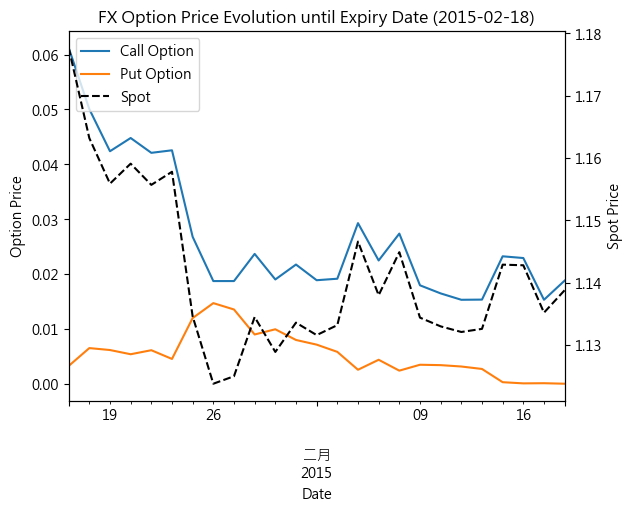

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
# minus sign
plt.rcParams['axes.unicode_minus'] = False
# set Chinese font
matplotlib.rc('font', family='Microsoft JhengHei')

# primary axis: option prices
ax = btPrem['OptionPrice_call'].plot(label='Call Option')
btPrem['OptionPrice_put'].plot(ax=ax, label='Put Option')

# create a second y-axis and plot spot there
ax2 = ax.twinx()
btPrem['Spot'].plot(ax=ax2, style='--', label='Spot', color='black')

# titles and axis labels
ax.set_title(f'FX Option Price Evolution until Expiry Date ({expDate.date()})')
ax.set_xlabel('Date')
ax.set_ylabel('Option Price')
ax2.set_ylabel('Spot Price')

# combined legend (from both axes)
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.show()

In [ ]:
# import minus and chinese
import matplotlib
# import minus sign
plt.rcParams['axes.unicode_minus'] = False
# set chinese font
matplotlib.rc('font', family='Microsoft JhengHei')
btPrem['OptionPrice'].plot()

KeyError: 'OptionPrice'

In [ ]:
expDate

Timestamp('2020-07-20 00:00:00')

In [ ]:
print(btPrem)

            Strike    Spot   Forward  DomesticRate  ForeignRate  ImpliedVol  \
2020-07-13    1.12  1.1319  1.132077      0.000896    -0.007160    0.077376   
2020-07-14    1.12  1.1331  1.133233      0.001008    -0.006030    0.081072   
2020-07-15    1.12  1.1433  1.143396      0.001017    -0.005014    0.085248   
2020-07-16    1.12  1.1408  1.140866      0.001010    -0.004172    0.076537   
2020-07-17    1.12  1.1391  1.139168      0.001151    -0.006047    0.086897   
2020-07-20    1.12  1.1456  1.145600      0.001285     0.001285    0.000000   

            TimeToExpiry  OptionPrice  
2020-07-13      0.019444     0.013101  
2020-07-14      0.016667     0.014007  
2020-07-15      0.013889     0.023478  
2020-07-16      0.011111     0.020900  
2020-07-17      0.008333     0.019220  
2020-07-20      0.000000     0.025600  


In [ ]:
# ignore warnings plz
import warnings
warnings.filterwarnings("ignore")

## create a fx option example and price it to its expiry date
PRICE_DATE = '2020-07-13'
# expDate = vol_exercise_date.loc[(CCY, PRICE_DATE)]['1W']
expDate = vol_exercise_date.at[(CCY, PRICE_DATE), '1M']

btDr = pd.bdate_range(start=PRICE_DATE, end=expDate, freq='B')
btPrem = pd.DataFrame(index=btDr)

# price it every day until expiry date
for date in btDr:
    priceDate = date
    expDate = expDate
    # delivery date is 2 business days after expiry date
    delivDate = pd.bdate_range(start=expDate, periods=3, freq='B')[2]
    CCY = CCY_LIST[0]
    spot = SPOT.loc[priceDate, CCY]

    spotData = SPOT.loc[priceDate, CCY]
    dayTenorData = FORWARD.loc[CCY].loc[priceDate]
    dayTenorData = pd.concat([pd.Series([spotData], index=['SP']), dayTenorData])


    # concat 
    tdyTenor = Fwd_date.loc[CCY].loc[priceDate].dropna()
    # get the diff between value date and spot date
    spTmp = tdyTenor.name
    tenorDayTmp = tdyTenor.values

    value_to_spot_days = []
    for i in tenorDayTmp:
        delta_days = (i - spTmp).days
        value_to_spot_days.append(delta_days)

    # tenorAcutalDay = [0, 1, 7, 14, 21, 30, 60, 91, 121, 182, 273, 365]
    tenorAcutalDay = value_to_spot_days

    tenors_days = tenorAcutalDay
    forward_prices = dayTenorData.values

    # Create the interpolation function
    forward_curve = create_forward_curve(tenors_days, forward_prices)
    # d1 = datetime.strptime(priceDate, '%Y-%m-%d')
    # d2 = datetime.strptime(expDate,   '%Y-%m-%d')
    # delta_days = (d2 - d1).days
    delta_days = (expDate - priceDate).days
    T_target = delta_days
    T_target = T_target / 360 # ~ 0.493 years
    F_interpolated = forward_curve(T_target)
    fwd = F_interpolated
    # print(spot, fwd)
    
    K_target = 1.12
    results = imply_vol3_F_knownK(
        currency=CCY, 
        Trade_date=pd.to_datetime(priceDate), 
        fixing_date=pd.to_datetime(expDate), # 29 days from 2012-09-03 (example)
        value_date=pd.to_datetime(delivDate), # Delivery date (e.g., T+2 from fixing)
        S=spot,
        K=K_target, # The strike that corresponds to the 65D on the smile
        market_forward_price=fwd
    )

    btPrem.loc[date, 'Strike'] = results['K']
    btPrem.loc[date, 'Spot'] = results['S']
    btPrem.loc[date, 'Forward'] = results['F']
    btPrem.loc[date, 'DomesticRate'] = results['rd']
    btPrem.loc[date, 'ForeignRate'] = results['rf_implied']
    btPrem.loc[date, 'ImpliedVol'] = results['sigmaImplied']
    btPrem.loc[date, 'TimeToExpiry'] = results['T_years']
    btPrem.loc[date, 'OptionPrice'] = fx_option_price_gk(S=results['S'], K=results['K'], T=results['T_years'], rd=results['rd'], rf=results['rf_implied'], sigma=results['sigmaImplied'], option_type='put')
    


Option already expired.


<Axes: >

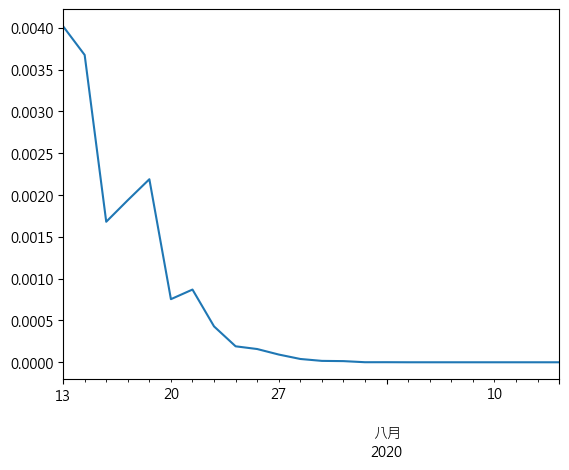

In [ ]:
# import minus and chinese
import matplotlib
# import minus sign
plt.rcParams['axes.unicode_minus'] = False
# set chinese font
matplotlib.rc('font', family='Microsoft JhengHei')
btPrem['OptionPrice'].plot()